In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from trainer import Trainer
from option import build_option
from utils.loss_utils import compute_embedding_loss, compute_normal_loss, \
        compute_param_loss, compute_nnl_loss, compute_miou, compute_type_miou_abc
from utils.main_utils import npy
from utils.abc_utils import mean_shift, compute_entropy, construction_affinity_matrix_type, \
        construction_affinity_matrix_normal
import scipy.stats as stats
import sys; sys.argv=['']
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
import numpy as np
import h5py

import pandas as pd


In [2]:
class args:
    SEED = 124654
    IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256

    RESOLUTION_3D = 0.03125
    SUBSAMPLE_FACTOR = 40
    POINTS_VISUAIZATION_STEP = SUBSAMPLE_FACTOR
    SAMPLING = 'random'

In [3]:
def pca_numpy(X):
    S, U = np.linalg.eig(X.T @ X)
    return S, U

def rotation_matrix_a_to_b(A, B):
    """
    Finds rotation matrix from vector A in 3d to vector B
    in 3d.
    B = R @ A
    """
    cos = np.dot(A, B)
    sin = np.linalg.norm(np.cross(B, A))
    u = A
    v = B - np.dot(A, B) * A
    v = v / (np.linalg.norm(v) + EPS)
    w = np.cross(B, A)
    w = w / (np.linalg.norm(w) + EPS)
    F = np.stack([u, v, w], 1)
    G = np.array([[cos, -sin, 0], [sin, cos, 0], [0, 0, 1]])
    # B = R @ A
    try:
        R = F @ G @ np.linalg.inv(F)
    except:
        R = np.eye(3, dtype=np.float32)
    return R

In [4]:
class MyTrainer(Trainer):
    def test_our_abc(self, points, normals, postprocess=True):
        if len(points.shape)==2:
            points = points.unsqueeze(dim=0)
            normals=normals.unsqueeze(dim=0)
        inputs_xyz_th = points.float().cuda().permute(0,2,1)
        inputs_n_th = normals.float().cuda().permute(0,2,1)
        if self.opt.input_normal:
            affinity_feat, type_per_point, normal_per_point, param_per_point, sub_idx = self.model(inputs_xyz_th, inputs_n_th, postprocess=postprocess)
        else:
            affinity_feat, type_per_point, param_per_point, sub_idx = self.model(inputs_xyz_th, inputs_n_th, postprocess=postprocess)
           
        inputs_xyz_sub = torch.gather(inputs_xyz_th, -1, sub_idx.unsqueeze(1).repeat(1,3,1))
        N_gt = normals.float().cuda()
        N_gt = torch.gather(N_gt, 1, sub_idx.unsqueeze(-1).repeat(1,1,3))

        loss_dict = {}
        
        if 'n' in self.opt.loss_class:
            normal_loss = compute_normal_loss(normal_per_point, N_gt)
            loss_dict['normal_loss'] = self.opt.normal_weight * normal_loss
        total_loss = 0
        for key in loss_dict:
            if 'loss' in key:
                total_loss += loss_dict[key]

        if postprocess:
                
            affinity_matrix = construction_affinity_matrix_type(inputs_xyz_sub, type_per_point, param_per_point, self.opt.sigma)
           
            affinity_matrix_normal = construction_affinity_matrix_normal(inputs_xyz_sub, N_gt, sigma=self.opt.normal_sigma, knn=self.opt.edge_knn) 

             
            spec_embedding_list = []
            weight_ent = []

            # use network feature
            feat_ent = self.opt.feat_ent_weight - float(npy(compute_entropy(affinity_feat)))
            weight_ent.append(feat_ent)
            spec_embedding_list.append(affinity_feat)
            
            # use geometry distance feature
            topk = self.opt.topK            
            e, v = torch.lobpcg(affinity_matrix, k=topk, niter=10)
            v = v / (torch.norm(v, dim=-1, keepdim=True) + 1e-16)

            dis_ent = self.opt.dis_ent_weight - float(npy(compute_entropy(v)))
            
            weight_ent.append(dis_ent)
            spec_embedding_list.append(v)
             
            # use edge feature
            edge_topk = self.opt.edge_topK
            e, v = torch.lobpcg(affinity_matrix_normal, k=edge_topk, niter=10)
            v = v / (torch.norm(v, dim=-1, keepdim=True) + 1e-16)
            
            edge_ent = self.opt.edge_ent_weight - float(npy(compute_entropy(v)))
           
            weight_ent.append(edge_ent)
            spec_embedding_list.append(v)
          
            # combine features
            weighted_list = []
            norm_weight_ent = weight_ent / np.linalg.norm(weight_ent)
            for i in range(len(spec_embedding_list)):
                weighted_list.append(spec_embedding_list[i] * weight_ent[i])

            spectral_embedding = torch.cat(weighted_list, dim=-1)
            
            print("begin mean shift")
            
            spec_cluster_pred = mean_shift(spectral_embedding, bandwidth=self.opt.bandwidth)
            cluster_pred = spec_cluster_pred
 
        return inputs_xyz_sub, cluster_pred, total_loss, loss_dict
    

In [ ]:
import time


In [119]:
FLAGS = build_option()
FLAGS.data_path = "/projects/grail/jamesn8nb/dataset_archives/ABC_final"
trainer = MyTrainer(FLAGS)
trainer.CHECKPOINT_PATH = "./abc_normal.tar"
trainer.load_checkpoint()
trainer.model.eval()

subsample_rate = 7000

log to ./log/test
parameters number: 1.389475  M
load checkpoint path: ./abc_normal.tar
Successfully Load Model with 117 epoch...


In [120]:
def test_points(points, normals, subsample_rate, args):
    if args.SAMPLING:
        if  subsample_rate > 0 and  args.SAMPLING=='random':
            print('random sampling')
            sub_idx = np.random.choice(np.arange(len(points)), subsample_rate)
            points = points[sub_idx]
            normals =normals[sub_idx]
        else:
            raise Exception("No other option for sampling") 

    start = time.time()
    trainer.opt.input_normal=True
    with torch.no_grad():
        inputs_xyz_sub, cluster_pred, total_loss, loss_dict = trainer.test_our_abc(torch.tensor(points),torch.tensor(normals))
    endtime = time.time()
    print('finished in',endtime - start)

    points_sub = inputs_xyz_sub[0].detach().cpu().numpy().T

    cluster_ids  = cluster_pred[0].detach().cpu().numpy()
    return points_sub, cluster_ids

In [121]:
def display_segmentation(points_sub, cluster_ids):
    markers = [{'size':2}]
    
    for i in np.unique(cluster_ids):
        if markers is None:
            marker = markers
        elif len(markers) == 1:
            marker = markers[0]
        else:
            marker = markers[i]
        pnt = points_sub[cluster_ids==i]
        if i == 0:
            fig = go.Figure(data=[go.Scatter3d(x=pnt[::,0], y=pnt[::,1], z=pnt[::,2], mode='markers', marker=marker)])
            continue
        fig.add_trace(go.Scatter3d(x=pnt[::,0], y=pnt[::,1], z=pnt[::,2], mode='markers', marker=marker))

    fig.update_layout(
        #autosize=False,
        #width=500,
        height=500,
        #margin=dict(
        #    l=50,
        #    r=50,
        #    b=100,
        #    t=100,
        #    pad=4
        #),
        #paper_bgcolor="LightSteelBlue",
    )
    fig.show()

## Test on synthetic point cloud

In [129]:
points = np.loadtxt('../brepopt/notebooks/test_point_cloud.txt')
normals = np.loadtxt('../brepopt/notebooks/test_point_cloud_normals.txt')
points_sub_onshape, cluster_ids_onshape = test_points(points, normals, subsample_rate, args)

random sampling
begin mean shift
finished in 449.1402359008789


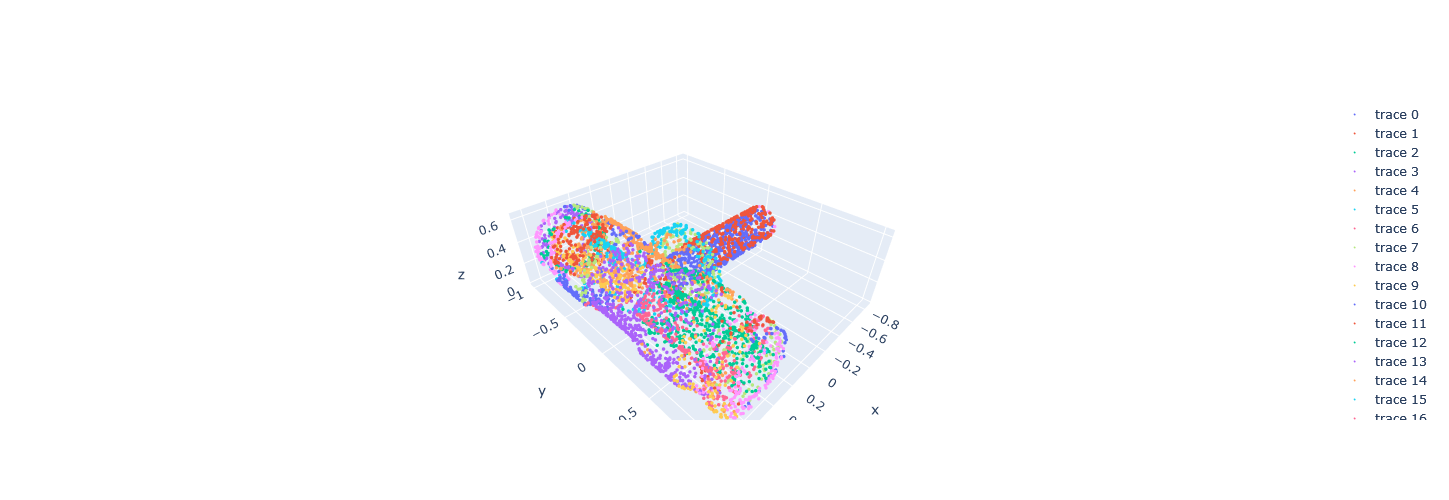

In [130]:
display_segmentation(points_sub_onshape, cluster_ids_onshape)

## Test on ABC Data

In [124]:
from dataloader.ABCDataset import ABCDataset
DATA_PATH = '/projects/grail/jamesn8nb/dataset_archives/ABC_final'

test_dataset = ABCDataset(DATA_PATH, FLAGS.test_dataset, opt=FLAGS, skip=FLAGS.val_skip)

In [125]:
batch = test_dataset[1]
points = batch['gt_pc']
normals = batch['gt_normal']
points_sub, cluster_ids = test_points(points, normals, subsample_rate, args)

random sampling
begin mean shift
finished in 401.6750531196594


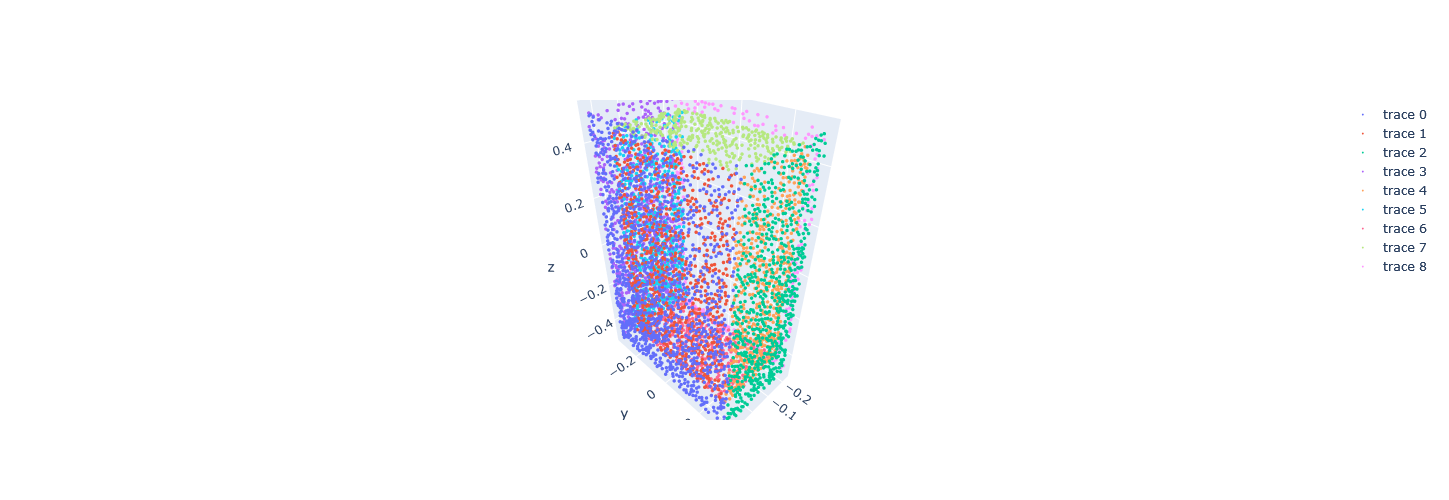

In [126]:
display_segmentation(points_sub, cluster_ids)

## Test on MiDaS outputs

In [ ]:
for i in range(12,16):
    print('processing item',i)
    points = np.loadtxt(f"inputs/points_fg_{i}.txt")
    normals = np.loadtxt(f"inputs/normals_fg_{i}.txt")
    
    
    points_sub, cluster_ids = test_points(points, normals, subsample_rate, args)
    np.savetxt(f'outputs/points_sub_{i}.txt', points_sub)
    np.savetxt(f'outputs/cluster_ids_{i}.txt', cluster_ids)

processing item 12
random sampling
begin mean shift


In [ ]:
import plotly.graph_objects as go
import plotly

ind = 12
points_sub_midas = np.loadtxt(f'outputs/points_sub_{ind}.txt')
cluster_ids_midas = np.loadtxt(f'outputs/cluster_ids_{ind}.txt')

display_segmentation(points_sub_midas, cluster_ids_midas)